In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import folium

%matplotlib inline

## Week 1

In [9]:
police_calls = pd.read_csv('../data/police_calls_2018.csv')
police_calls.head()

,Event Number,Call Received,Complaint Number,Shift,Tencode,Tencode Description,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Sector,Zone,Latitude,Longitude,geometry,zipcode,PO
0,PD201800174484,02/16/2018 07:09:00 PM,20180155542,B,93,Traffic Violation,3,CITATION - TRAFFIC,600.0,ALBANY DR,521B,H,23,36.210,-86.600,POINT (-86.59999999999999 36.21),37076,HERMITAGE
1,PD201800174650,02/16/2018 08:02:00 PM,20180155684,B,93,Traffic Violation,9,SUBJECT WARNED,5800.0,OLD HICKORY BLVD,5F34,H,21,36.169,-86.601,POINT (-86.601 36.169),37076,HERMITAGE
2,PD201800175038,02/16/2018 10:16:00 PM,20180156001,B,3,Administrative/Special Assignment,6,ASSISTED OTHER UNIT,3700.0,JAMES KAY LN,521B,H,21,36.178,-86.616,POINT (-86.616 36.178),37076,HERMITAGE
3,PD201800174217,02/16/2018 05:58:00 PM,20180155321,B,87,Safety Hazard,3,CITATION - TRAFFIC,0.0,MM 221 4 I40 E,5122,H,23,36.170,-86.591,POINT (-86.59100000000001 36.17),37076,HERMITAGE
4,PD201800173907,02/16/2018 04:19:00 PM,20180155047,B,93,Traffic Violation,9,SUBJECT WARNED,1300.0,TULIP GROVE RD,521B,H,23,36.175,-86.596,POINT (-86.596 36.175),37076,HERMITAGE


In [13]:
police_calls.tail(3)

,Call Received,Shift,Tencode,Tencode Description,Disposition Code,Disposition Description,Unit Dispatched,Sector,Zone,Latitude,Longitude,zipcode,PO
718018,08/29/2018 09:11:36 AM,A,45,Vehicle Accident - Property Damage,1,M.P.D. REPORT COMPLED,3T73,S,31,35.994,-86.685,37027,BRENTWOOD
718019,08/08/2018 10:15:20 AM,A,43,Want Officer for Investigation / Assistance,11,DISREGARD / SIGNAL 9,NaN,W,25,36.094,-87.038,37143,PEGRAM
718020,08/13/2018 11:51:29 AM,A,96,Business Check,4,ASSISTED CITIZEN,5252,W,23,36.094,-87.038,37143,PEGRAM


In [10]:
police_calls.columns

Index(['Event Number', 'Call Received', 'Complaint Number', 'Shift', 'Tencode',
       'Tencode Description', 'Disposition Code', 'Disposition Description',
       'Block', 'Street Name', 'Unit Dispatched', 'Sector', 'Zone', 'Latitude',
       'Longitude', 'geometry', 'zipcode', 'PO'],
      dtype='object')

In [14]:
police_calls.shape

(718021, 13)

In [11]:
police_calls = police_calls[['Call Received', 'Shift', 'Tencode',
               'Tencode Description', 'Disposition Code', 'Disposition Description', 'Unit Dispatched', 
               'Sector', 'Zone', 'Latitude', 'Longitude', 'zipcode', 'PO']]

In [15]:
police_calls.columns = ['call_time', 'shift', 'tencode', 'tencode_desc', 'disposition', 'disposition_desc',
                        'unit_dispatched', 'sector', 'zone', 'lat', 'lng', 'zipcode', 'po']

In [17]:
police_calls.disposition_desc.unique()

array(['CITATION - TRAFFIC', 'SUBJECT WARNED', 'ASSISTED OTHER UNIT',
       'GONE ON ARRIVAL', 'ASSISTED CITIZEN', 'COMMUNITY POLICING',
       'LOCATION/BUILDING SECURE', 'DISREGARD / SIGNAL 9',
       'M.P.D. REPORT COMPLED', 'ADVISED IN CIVIL CASE', 'FALSE CALL',
       'NO RESPONSE', 'ARREST, CUSTODIAL OR CITATION',
       'ASSISTANCE REFUSED', 'ADVISORY / NOTICE FORM GIVEN', nan],
      dtype=object)

In [18]:
len(police_calls.disposition_desc.unique())

16

In [20]:
police_calls = police_calls.loc[police_calls.disposition_desc.notnull()]
police_calls = police_calls.loc[~police_calls.disposition_desc.isin(['DISREGARD / SIGNAL 9', 'NO RESPONSE'])]
police_calls.shape

(624841, 13)

In [23]:
tencode_counts = police_calls.tencode_desc.value_counts()

In [26]:
tencode_counts = tencode_counts. reset_index()
tencode_counts.columns = ['tencode', 'tencode_counts']
tencode_counts.head()

,tencode,tencode_counts
0,Business Check,154763
1,Traffic Violation,141283
2,Want Officer for Investigation / Assistance,100465
3,Administrative/Special Assignment,34094
4,Community Policing Activity,34001


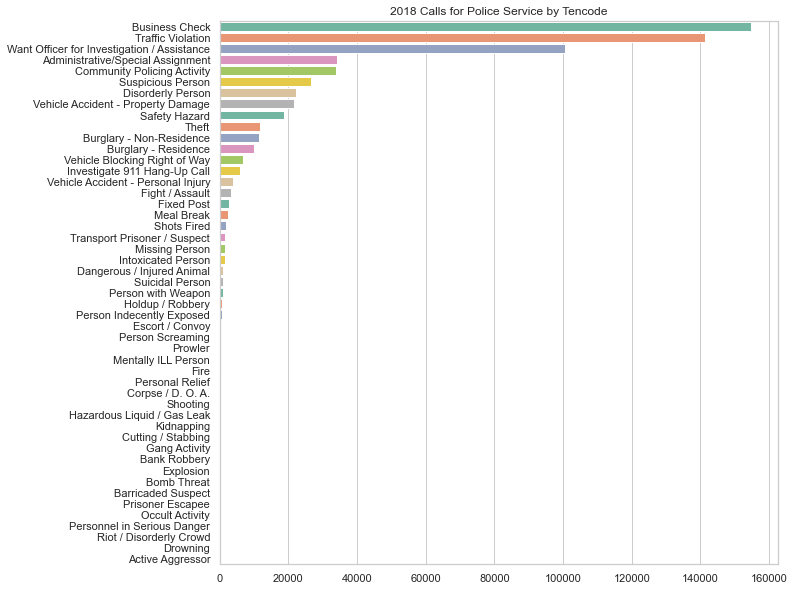

In [28]:
plt.figure(figsize = (10, 10))
sns.set(style="whitegrid")
sns.barplot(x = 'tencode_counts', y = 'tencode', data = tencode_counts, palette = 'Set2')
plt.xlabel('')
plt.ylabel('')
plt.title('2018 Calls for Police Service by Tencode');

In [130]:
call_zip_counts = police_calls.zipcode.value_counts()

In [131]:
call_zip_counts = call_zip_counts. reset_index()
call_zip_counts.columns = ['zipcode', 'number_of_calls']
call_zip_counts.head()

,zipcode,number_of_calls
0,37203,61962
1,37209,52248
2,37207,48750
3,37211,47528
4,37115,39879


In [132]:
call_zip_counts.zipcode = call_zip_counts.zipcode.astype(str)

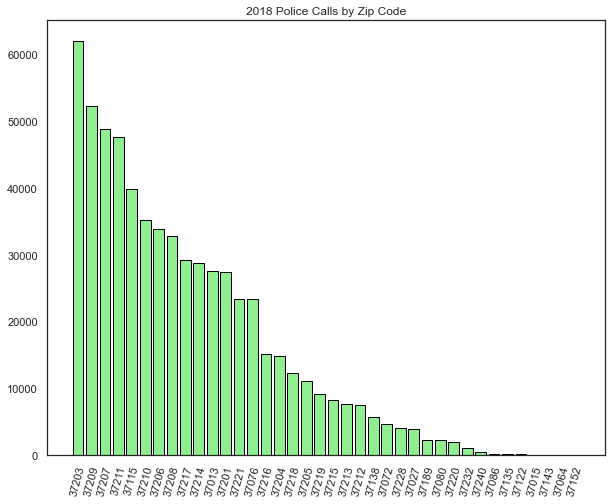

In [133]:
zipcodes = list(call_zip_counts.sort_values('zipcode').zipcode)
sns.set(style='white')

plt.figure(figsize = (10, 8))
plt.bar('zipcode', 'number_of_calls', data = call_zip_counts, color = 'lightgreen', edgecolor = 'black')
plt.xticks(ticks = zipcodes, rotation = 75)
plt.title('2018 Police Calls by Zip Code');

In [66]:
police_calls.call_time = pd.to_datetime(police_calls.call_time)
police_calls.head(2)

,call_time,shift,tencode,tencode_desc,disposition,disposition_desc,unit_dispatched,sector,zone,lat,lng,zipcode,po
0,2018-02-16 19:09:00,B,93,Traffic Violation,3,CITATION - TRAFFIC,521B,H,23,36.210,-86.600,37076,HERMITAGE
1,2018-02-16 20:02:00,B,93,Traffic Violation,9,SUBJECT WARNED,5F34,H,21,36.169,-86.601,37076,HERMITAGE


In [68]:
police_calls['month'] = police_calls.call_time.dt.month
police_calls.head(2)

,call_time,shift,tencode,tencode_desc,disposition,disposition_desc,unit_dispatched,sector,zone,lat,lng,zipcode,po,month
0,2018-02-16 19:09:00,B,93,Traffic Violation,3,CITATION - TRAFFIC,521B,H,23,36.210,-86.600,37076,HERMITAGE,2
1,2018-02-16 20:02:00,B,93,Traffic Violation,9,SUBJECT WARNED,5F34,H,21,36.169,-86.601,37076,HERMITAGE,2


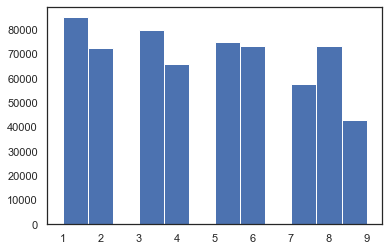

In [70]:
plt.hist(police_calls.month, bins = 12);

In [72]:
max(police_calls.call_time)

Timestamp('2018-09-21 03:13:24')

## Week 2

In [75]:
hub = pd.read_csv('../data/hubNashville_2018.csv')
hub.head()

,Request #,Status,Request Type,Subrequest Type,Additional Subrequest Type,Date / Time Opened,Date / Time Closed,Request Origin,Zipcode,Latitude,Longitude
0,45480,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,Blocking the Right of Way,2018-02-12 14:00:20,02/12/2018 03:48:14 PM,Phone,37115.0,36.296917,-86.699162
1,45482,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,Blocking the Right of Way,2018-02-12 14:00:21,02/12/2018 03:49:13 PM,Phone,37076.0,36.215403,-86.588513
2,43742,Closed,"Trash, Recycling & Litter",Litter,Litter,2018-02-02 21:18:15,02/07/2018 05:04:33 PM,Phone,37076.0,36.187902,-86.607286
3,49069,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,Blocking the Right of Way,2018-02-23 23:27:07,02/27/2018 09:06:16 PM,hubNashville Community,37203.0,36.153761,-86.788745
4,44743,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,Blocking the Right of Way,2018-02-08 14:00:04,02/08/2018 03:01:50 PM,Phone,37210.0,36.154836,-86.763345


In [76]:
hub.isnull().sum()

Request #                       0
Status                          0
Request Type                    0
Subrequest Type                 0
Additional Subrequest Type     18
Date / Time Opened              0
Date / Time Closed            300
Request Origin                  0
Zipcode                         0
Latitude                        0
Longitude                       0
dtype: int64

In [78]:
hub.columns = ['request_id', 'status', 'request_type', 'subrequest_type', 'add_subreqest_type', 'opened', 'closed', 
               'origin', 'zipcode', 'lat', 'lng']

In [79]:
hub = hub.loc[hub.closed.notnull()]
hub.shape

(80866, 11)

In [80]:
hub.opened = pd.to_datetime(hub.opened)
hub.closed = pd.to_datetime(hub.closed)

In [81]:
hub['resolution_time'] = hub.closed - hub.opened

In [82]:
hub.head()

,request_id,status,request_type,subrequest_type,add_subreqest_type,opened,closed,origin,zipcode,lat,lng,resolution_time
0,45480,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,Blocking the Right of Way,2018-02-12 14:00:20,2018-02-12 15:48:14,Phone,37115.0,36.296917,-86.699162,0 days 01:47:54
1,45482,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,Blocking the Right of Way,2018-02-12 14:00:21,2018-02-12 15:49:13,Phone,37076.0,36.215403,-86.588513,0 days 01:48:52
2,43742,Closed,"Trash, Recycling & Litter",Litter,Litter,2018-02-02 21:18:15,2018-02-07 17:04:33,Phone,37076.0,36.187902,-86.607286,4 days 19:46:18
3,49069,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,Blocking the Right of Way,2018-02-23 23:27:07,2018-02-27 21:06:16,hubNashville Community,37203.0,36.153761,-86.788745,3 days 21:39:09
4,44743,Closed,"Streets, Roads & Sidewalks",Blocking the Right of Way,Blocking the Right of Way,2018-02-08 14:00:04,2018-02-08 15:01:50,Phone,37210.0,36.154836,-86.763345,0 days 01:01:46


In [86]:
slow_to_resolve = hub.loc[hub.resolution_time > '365 days']
slow_to_resolve.shape

(288, 12)

In [92]:
grouped_slow_requests = slow_to_resolve.groupby(['zipcode', 'request_type'])['request_id'].agg('count').reset_index()

In [95]:
grouped_slow_requests = grouped_slow_requests.rename(columns = {'request_id': 'request_count'})
grouped_slow_requests = grouped_slow_requests.sort_values('request_count', ascending = False)
grouped_slow_requests.head()

,zipcode,request_type,request_count
33,37206.0,"Streets, Roads & Sidewalks",48
37,37207.0,"Streets, Roads & Sidewalks",17
46,37209.0,Property Violations,14
12,37115.0,Property Violations,13
40,37208.0,Property Violations,13


#### SQLite

In [103]:
conn = sql.connect('../data/metro_survey.db')
cur = conn.cursor()

In [104]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
tables = (cur.fetchall())

In [105]:
print(tables)

[('codes',), ('equality_and_access',), ('general_services',), ('info',), ('overall',), ('recreation',), ('safety',), ('transportation',)]


In [106]:
query = 'SELECT * FROM safety;'

In [107]:
safety_df = pd.read_sql(query, conn)

In [109]:
query = 'SELECT * FROM info;'

In [110]:
respondent_info = pd.read_sql(query, conn)

In [118]:
safety_exp1 = pd.merge(safety_df, respondent_info, on = 'Id')
safety_exp1.shape

(2171, 30)

In [112]:
query = '''
SELECT *
FROM safety JOIN info on safety.Id = info.Id;
'''

In [113]:
safety_exp2 = pd.read_sql(query, conn)
safety_exp2.shape

(2171, 31)

In [116]:
print(safety_exp1.columns)
print(safety_exp2.columns)

Index(['index_x', 'Id', 'Crime Prevention', 'Police - Overall',
       'Fire and EMS - Overall', 'Police Visibility', 'Traffic Enforcement',
       'Police Professionalism', 'Police Response Time', 'Fire Services',
       'Fire Response Time', 'Emergency Medical Services (EMS)',
       'EMS Response Time', 'Fire Professionalism', 'EMS Professionalism',
       '911 Services', 'Non-Emergency Number', 'index_y', 'Period', 'Date',
       'ZIP Code', 'Quality of Life', 'Overall Feeling of Safety',
       'Neighborhood Safety', 'Neighborhood Appearance',
       'Nashville as Residence', 'Nashville as Place to Raise Children',
       'Nashville as Workplace', 'Nashville as Retirement Place',
       'Gender Identity'],
      dtype='object')
Index(['index', 'Id', 'Crime Prevention', 'Police - Overall',
       'Fire and EMS - Overall', 'Police Visibility', 'Traffic Enforcement',
       'Police Professionalism', 'Police Response Time', 'Fire Services',
       'Fire Response Time', 'Emergency Medi

In [119]:
safety_exp1 = safety_exp1[['Id','Crime Prevention', 'Police - Overall', 'Police Visibility', 'Police Professionalism', 
                           'Police Response Time', 'ZIP Code']]
safety_exp1.head()

,Id,Crime Prevention,Police - Overall,Police Visibility,Police Professionalism,Police Response Time,ZIP Code
0,1,Very Dissatisfied,Very Dissatisfied,Neutral,Neutral,Dissatisfied,37208
1,2,Dissatisfied,Satisfied,Satisfied,Satisfied,Don't Know,37211
2,3,Neutral,Neutral,Neutral,Neutral,Satisfied,37208
3,4,Satisfied,Very Satisfied,Satisfied,Very Satisfied,Don't Know,37203
4,5,Don't Know,Neutral,Don't Know,Don't Know,Don't Know,37138


In [120]:
safety_grouped = safety_exp1.groupby(['ZIP Code', 'Police - Overall'])['Id'].agg('count').reset_index()

In [122]:
safety_grouped.columns = ['zipcode', 'overall_police_satisfaction', 'respondent_count']

In [129]:
safety_grouped.head(2)

,zipcode,overall_police_satisfaction,respondent_count
0,37013,Dissatisfied,28
1,37013,Don't Know,8


In [134]:
call_zip_counts.head(2)

,zipcode,number_of_calls
0,37203,61962
1,37209,52248


In [136]:
safety_grouped.zipcode = safety_grouped.zipcode.astype(str)

In [137]:
police_calls_and_survey = pd.merge(safety_grouped, call_zip_counts, on = 'zipcode', how = 'outer')
police_calls_and_survey.head()

,zipcode,overall_police_satisfaction,respondent_count,number_of_calls
0,37013,Dissatisfied,28.0,27608.0
1,37013,Don't Know,8.0,27608.0
2,37013,Neutral,36.0,27608.0
3,37013,Satisfied,79.0,27608.0
4,37013,Very Dissatisfied,8.0,27608.0


In [139]:
top5_calls = ['37203', '37209', '37207', '37211', '37115']

In [140]:
police_calls_and_survey.loc[police_calls_and_survey.zipcode.isin(top5_calls)]

,zipcode,overall_police_satisfaction,respondent_count,number_of_calls
30,37115,Dissatisfied,13.0,39879.0
31,37115,Don't Know,2.0,39879.0
32,37115,Neutral,20.0,39879.0
33,37115,Satisfied,37.0,39879.0
34,37115,Very Dissatisfied,5.0,39879.0
35,37115,Very Satisfied,11.0,39879.0
51,37203,Dissatisfied,9.0,61962.0
52,37203,Don't Know,5.0,61962.0
53,37203,Neutral,11.0,61962.0
54,37203,Satisfied,23.0,61962.0


In [145]:
folium.Map(location = [36.1612, -86.7775], zoom_start = 12)

In [144]:
slow_to_resolve.head(2)

,request_id,status,request_type,subrequest_type,add_subreqest_type,opened,closed,origin,zipcode,lat,lng,resolution_time
244,112161,Closed,Property Violations,Residential Complaint,Residential Complaint,2018-10-25 18:28:49,2020-03-18 08:12:19,hubNashville Community,37115.0,36.258170,-86.69575,509 days 13:43:30
250,123468,Closed,Public Safety,Abandoned Vehicles,Abandoned Vehicles,2018-12-14 13:12:04,2020-06-29 14:41:39,Phone,37207.0,36.245086,-86.77335,563 days 01:29:35


In [151]:
nash_map = folium.Map(location = [36.1612, -86.7775], zoom_start = 12)

for row_index, row_values in slow_to_resolve.iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['request_type'] + ': ' + str(row_values['resolution_time']))
    icon=folium.Icon(color="orange",icon="exclamation", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(nash_map)
nash_map    